## ComEd Electricity Price Prediction

Problem Solving Framework:

* Business Issue Understanding
* Data understanding and Data Preparation(fetching from API)
* Analysis/ Modeling 
    * Feature Engineering
    * Tweak Paramteres
* Validation
    * Cross Validation
    * Select an algorithm (**Linear Regression**)
    * Fit the model
    * Train and Test
    * Find Accuracy of the Predicted Values
* Visualization/ Presentation.

## Business Issue Understanding

ComEd, an Exelon Company provides electricity and is the largest electric utility
in Illinois, serving Chicago and Northern Illinois. They have APIs1 for 5-minute
prices for ComEd's Hourly Pricing Program. Dierent data that can be found
using these APIs are, returns all 5-minute prices from the last 24 hours, returns
5-minute prices between the times provided, inclusively and hour average prices.
We can use this data to predict future prices using linear regression models.

## Customer and Target Audience

* Customer - Akash Narayan, Engineer at Mortenson, Chicago
* Email: akash.narayan@mortenson.com

I selected this customer because he lives in Chicago working full time so he
knows about the price he is paying for electricity and it can be helpful for such
a customer to analyze the prices and can help them reduce energy costs.

In [1]:
# from urllib2.request import urlopen
import requests
import json
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import dateutil
import pytz
from sklearn import linear_model, cross_validation
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import Latex

/Users/arpitgarg/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Taking CST as our timezone and setting a property of N prior days that we will use in future for our analysis.

In [38]:
Chicago=pytz.timezone("America/Chicago")
Chicago
N_priordays=5

## Data Understanding and Preparation

Using ComEd's pricing API for every 5 minutes, we gather the data for the dates for which we want to perform our analysis.

In [30]:
def get_prices(startDate,endDate=None):
    '''
    gets data from ComEd
    startDate and endDate should be in YYYYMMDDhhmm
    output is a list of {"1234",5.5}, where "1234" is the UTC in seconds and 5.5 is the price
    '''
    endDate = startDate if endDate is None else endDate
    startDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(startDate)))
    endDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(endDate)))
    format="%Y%m%d%H%M"
    startDate=startDate.strftime(format)
    endDate=endDate.strftime(format)
    URL="https://hourlypricing.comed.com/api?type=5minutefeed&datestart=STARTDATE&dateend=ENDDATE&format=json"
    temp=URL.replace("STARTDATE",startDate).replace("ENDDATE",endDate)
    print(temp)
    r = requests.get(url=temp)
    data = r.json()
#     print [int(obj.values()[1])/1000 for obj in data]
    out={}
    for obj in data:
        try:
            ts=int(obj.values()[1])/1000
            dt=Chicago.normalize(Chicago.localize(datetime.datetime.fromtimestamp(ts)))
            out[dt]=float(obj.values()[0])
        except Exception:
            pass
#     print out
    return out


In [50]:
startDate="20170601"
endDate="20170630"

# startDate="20171101"
# endDate="20171130"

data=get_prices(startDate,endDate)
print(str(len(data.keys()))+" records of data")

https://hourlypricing.comed.com/api?type=5minutefeed&datestart=201706010000&dateend=201706300000&format=json
8287 records of data


In [32]:
for k,v in data.iteritems():
    print k,v

2017-12-01 11:30:00-06:00 3.0
2017-12-01 18:05:00-06:00 2.4
2017-12-02 01:10:00-06:00 2.4
2017-12-02 08:15:00-06:00 -2.6
2017-12-02 15:20:00-06:00 2.4
2017-12-02 23:45:00-06:00 2.2
2017-12-02 05:05:00-06:00 2.3
2017-12-01 04:15:00-06:00 2.3
2017-12-02 12:10:00-06:00 2.5
2017-12-02 19:15:00-06:00 3.1
2017-12-02 21:20:00-06:00 2.4
2017-12-01 01:55:00-06:00 2.2
2017-12-01 09:00:00-06:00 3.0
2017-12-01 08:05:00-06:00 2.9
2017-12-01 15:10:00-06:00 4.3
2017-12-02 01:45:00-06:00 2.4
2017-12-02 08:50:00-06:00 3.0
2017-12-02 15:55:00-06:00 2.5
2017-12-02 01:40:00-06:00 2.4
2017-12-01 12:50:00-06:00 2.2
2017-12-02 08:45:00-06:00 2.8
2017-12-02 15:50:00-06:00 5.8
2017-12-01 22:25:00-06:00 2.4
2017-12-01 05:35:00-06:00 5.3
2017-12-01 04:40:00-06:00 2.9
2017-12-01 22:20:00-06:00 2.4
2017-12-02 21:25:00-06:00 2.4
2017-12-02 05:25:00-06:00 2.6
2017-12-02 12:30:00-06:00 2.4
2017-12-01 22:15:00-06:00 2.4
2017-12-02 19:30:00-06:00 2.9
2017-12-01 09:25:00-06:00 2.6
2017-12-02 05:20:00-06:00 2.8
2017-12-0

In [33]:
def inrange(indatetime):
    '''
    returns true if datetime is between midnight and 5 AM, and a weekday
    '''
    hourflag=(datetime.time(23,0,0)<=indatetime.time()) or (indatetime.time()<=datetime.time(5,0,0))
    dayflag=0<=indatetime.weekday()<=4
    return hourflag and dayflag

In [34]:
# dates=sorted([dt for dt in data.keys() if inrange(dt)])
dates=sorted([dt for dt in data.keys()])
print(len(dates))
dates[0]

572


datetime.datetime(2017, 12, 1, 0, 20, tzinfo=<DstTzInfo 'America/Chicago' CST-1 day, 18:00:00 STD>)

## Linear Regression

In statistics, linear regression is a linear approach for modeling the relationship between a **scalar dependent variable** called **y** and one or more **explanatory variables (or independent variables)** denoted **X**. The case of one explanatory variable is called **simple linear regression**. For **more than one** explanatory variable, the process is called **multiple linear regression**.

When the goal is prediction, or forecasting, or error reduction, linear regression can be used to fit a predictive model to an observed data set of y and X values. After developing such a model, if an additional value of X is then given without its accompanying value of y, the fitted model can be used to make a prediction of the value of y.

\begin{align}
y_i = \beta_0 1 + \beta_1 x_{i1} + \beta_2 x_{i2} + ... + \beta_N x_{iN} + \epsilon_i = x_i^T\beta, \hspace{1cm}   i = 1, 2, ..N \\
\end{align}


## Features for our linear regresion model (Analysis)

**Independent or explanatory variables**

* **Prior Price** - Price prior to the current price of current time.
* **Historical Average** - Average of all the historical prices for N days at that particular time.

We take these features to see if our model gives good results for the predicted values of the electricity prices.


In [35]:
def featureEngineering(data, dates, N_priordays):
    y=[]
    A=[]
    indices=[]
    count=0
    historical_N=range(1,N_priordays+1)
    final = {'date':[], 'price':[], 'prior':[], 'historical_average_price':[]}
    for dt in range(len(dates)):
        try:
            price=data[dates[dt]]
            final['date'].append(dates[dt])
            final['price'].append(price)
            
            # Taking prior price of current time
            prior=dates[dt]-datetime.timedelta(minutes=5)
    #         print(prior)
            prior_price=data[prior]
            final['prior'].append(prior_price)
    #         print(prior_price)
            
            # Calculating historical dates of same time
            historical=[dates[dt]-datetime.timedelta(days=n) for n in historical_N]
    #         print(historical)
            
            # Prices for all the historical days
            historical_price=[data[h] for h in historical]
    #         print(historical_price)
            
            # Calculating average of all the historical prices
            historical_average=np.average(historical_price)
            final['historical_average_price'].append(historical_average)
    #         print(historical_average)
            
            y.append([price])
    #         print(y)
            A.append([prior_price,historical_average,1])
    #         print(A)
            indices.append(dates[dt])
        except Exception:
            count+=1
    #         print("in exception with dt="+str(dt))
            pass
#     print(count)
    A=np.matrix(A)
    y=np.matrix(y)
    return(A, y, indices, final)

In [36]:
A, y, indices, final = featureEngineering(data, dates, N_priordays)

In [37]:
len(final['historical_average_price'])

0

In [11]:
df = pd.DataFrame.from_dict(final, orient='index').T.dropna()

In [12]:
# print("y:\n"+str(y))
# print("A:\n"+str(A))
print(len(y), len(A))
A_inv=np.linalg.pinv(A)
x=np.dot(A_inv,y)
Ax=np.dot(A,x)
err=y-Ax
print("x:\n"+str(x))
#print("err:\n"+str(err))
print("dim(y): "+str(y.shape))
print("dim(Ax): "+str(Ax.shape))
print("dim(err): "+str(err.shape))
print("dim(indices): "+str(len(indices)))

(1, 1)


LinAlgError: Arrays cannot be empty

In [ ]:
df = df.dropna()
df.set_index('date')

In [13]:
df.date = pd.to_datetime(df.date)
df.date.head()

Series([], Name: date, dtype: datetime64[ns])

In [14]:
df[:5]

,date,prior,price,historical_average_price


In [ ]:
plt.hist(err, 100, normed=1, facecolor='green', alpha=0.75)
plt.show()

In [ ]:
orig = df

In [ ]:
target = df['price']
dates = df['date']
print(target.head())
print(dates.head())

In [ ]:
len(dates[1767:])

In [ ]:
df = df.drop('price', axis=1)

In [ ]:
df = df.drop('date', axis=1)

In [ ]:
df.head()

## Validation

Dividing the data into training and testing using cross validation and then using linear regressio model to fit on the training data

In [ ]:
df_train,df_test,target_train,target_test = cross_validation.train_test_split(df, target, test_size = 0.25)

In [ ]:
print('length of X_train and x_test: ', len(df_train), len(df_test))

In [ ]:
regr = linear_model.LinearRegression()

In [ ]:
regr.fit(df_train, target_train)

In [ ]:
# Make predictions using the testing set
price_pred = regr.predict(df_test)
print(len(price_pred))

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_test, price_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, price_pred))

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(dates,df['prior'], color="red")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Prior Price')
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(dates,df['historical_average_price'], color="green")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Prior Price')
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(dates[len(target_train):],price_pred, color="blue")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.show()

In [ ]:
plt.hist2d(price_pred, np.arange(len(price_pred)))

In [ ]:
# Plot outputs
plt.scatter(df_test.historical_average_price, target_test,  color='black')
# plt.plot(df_test.historical_average_price, price_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [40]:
accuracies = [0.16,0.10,0.10,0.37,0.38,0.6,0.58,0.32,0.32,0.21,0.02]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

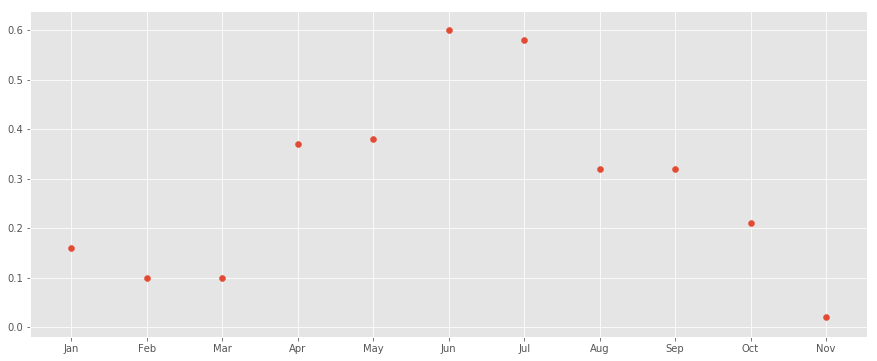

In [49]:
plt.figure(figsize=(15,6))
plt.xticks(np.arange(1,12),months)
plt.scatter(np.arange(1,12), accuracies)

## Results

* Month wise different accuracies.. difficult to predict when the weather changes but better during summer or constant weather time.

    * **January** - 0.16
    * **February** - 0.10
    * **March** - 0.10
    * **April** - 0.37
    * **May** - 0.38
    * **June** - 0.6
    * **July** - 0.58
    * **August** - 0.32
    * **September** - 0.32
    * **October** - 0.21   
    * **November** - 0.02
    * **December** - Not much data yet    

In [ ]:
np.savetxt("err.csv", ERR, delimiter=",")

In [ ]:
class pricePrediction():
    
    def __init__(self):
#         self.startDate = startDate
#         self.endDate = endDate
        self.Chicago=pytz.timezone("America/Chicago")
        N_priordays=5
    
    def get_prices(startDate,endDate=None):
        '''
        gets data from ComEd
        startDate and endDate should be in YYYYMMDDhhmm
        output is a list of {"1234",5.5}, where "1234" is the UTC in seconds and 5.5 is the price
        '''
        endDate = startDate if endDate is None else endDate
        startDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(startDate)))
        endDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(endDate)))
        format="%Y%m%d%H%M"
        startDate=startDate.strftime(format)
        endDate=endDate.strftime(format)
        URL="https://hourlypricing.comed.com/api?type=5minutefeed&datestart=STARTDATE&dateend=ENDDATE&format=json"
        temp=URL.replace("STARTDATE",startDate).replace("ENDDATE",endDate)
        print(temp)
        r = requests.get(url=temp)
        data = r.json()
    #     print [int(obj.values()[1])/1000 for obj in data]
        out={}
        for obj in data:
            try:
                ts=int(obj.values()[1])/1000
                dt=Chicago.normalize(Chicago.localize(datetime.datetime.fromtimestamp(ts)))
                out[dt]=float(obj.values()[0])
            except Exception:
                pass
    #     print out
        return out
    def featureEngineering(data, dates, N_priordays):
        y=[]
        A=[]
        indices=[]
        count=0
        historical_N=range(1,N_priordays+1)
        final = {'date':[], 'price':[], 'prior':[], 'historical_average_price':[]}
        for dt in range(len(dates)):
            try:
                price=data[dates[dt]]
                final['date'].append(dates[dt])
                final['price'].append(price)

                # Taking prior price of current time
                prior=dates[dt]-datetime.timedelta(minutes=5)
        #         print(prior)
                prior_price=data[prior]
                final['prior'].append(prior_price)
        #         print(prior_price)

                # Calculating historical dates of same time
                historical=[dates[dt]-datetime.timedelta(days=n) for n in historical_N]
        #         print(historical)

                # Prices for all the historical days
                historical_price=[data[h] for h in historical]
        #         print(historical_price)

                # Calculating average of all the historical prices
                historical_average=np.average(historical_price)
                final['historical_average_price'].append(historical_average)
        #         print(historical_average)

                y.append([price])
        #         print(y)
                A.append([prior_price,historical_average,1])
        #         print(A)
                indices.append(dates[dt])
            except Exception:
                count+=1
        #         print("in exception with dt="+str(dt))
                pass
    #     print(count)
        A=np.matrix(A)
        y=np.matrix(y)
        return(A, y, indices, final)

